In [27]:
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import adjusted_rand_score

In [28]:
data = pd.read_csv('wine.csv')
data.head()

,Type,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Prolin
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [29]:
LABEL_IDX = 0

In [30]:
Xs = data[data.columns[1:]]
Xs.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Prolin
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [31]:
classes, counts = np.unique(data.loc[:, data.columns[LABEL_IDX]], return_counts=True)
dict(zip(classes, counts))

{1: 59, 2: 71, 3: 48}

In [32]:
y = data.loc[:, data.columns[LABEL_IDX]].apply(lambda status: np.where(classes == status)[0][0])
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Type, dtype: int64

In [33]:
# X_norm = StandardScaler(copy=True, with_mean=True, with_std=True).fit_transform(Xs)
X_norm = MinMaxScaler(copy=True, feature_range=(0, 1)).fit_transform(Xs)
# X_norm = Xs

In [34]:
X_norm.mean(axis=0)

array([0.51858368, 0.31548386, 0.53824431, 0.45850226, 0.32327797,
       0.45348702, 0.356386  , 0.43746025, 0.3725233 , 0.32236262,
       0.38817027, 0.49145985, 0.33444598])

In [35]:
X_norm.std(axis=0)

array([0.21303761, 0.22015882, 0.14629534, 0.17165823, 0.15480769,
       0.21520364, 0.21013691, 0.23415709, 0.18004696, 0.19724954,
       0.18530781, 0.25933819, 0.22398121])

In [36]:
np.random.rand(3)

array([0.39401008, 0.49328034, 0.48916778])

In [37]:
reducer = PCA(n_components=2)
X_reduced = reducer.fit_transform(X_norm)

In [38]:
colours = ["b", "g", "r", "c", "m", "y", "k", "w"]

In [39]:
def display_clusters(labels, title):
    plt.figure(figsize=(12, 12))
    unique_labels = np.unique(labels)
    for i in range(len(unique_labels)):
        label = unique_labels[i]
        cur_xs = X_reduced[labels == label, 0]
        cur_ys = X_reduced[labels == label, 1]
        plt.scatter(cur_xs, cur_ys, color=colours[i], alpha=0.5, label=label)
    plt.title(title)
    plt.xlabel("X координата")
    plt.ylabel("Y координата")
    plt.legend()
    plt.show()

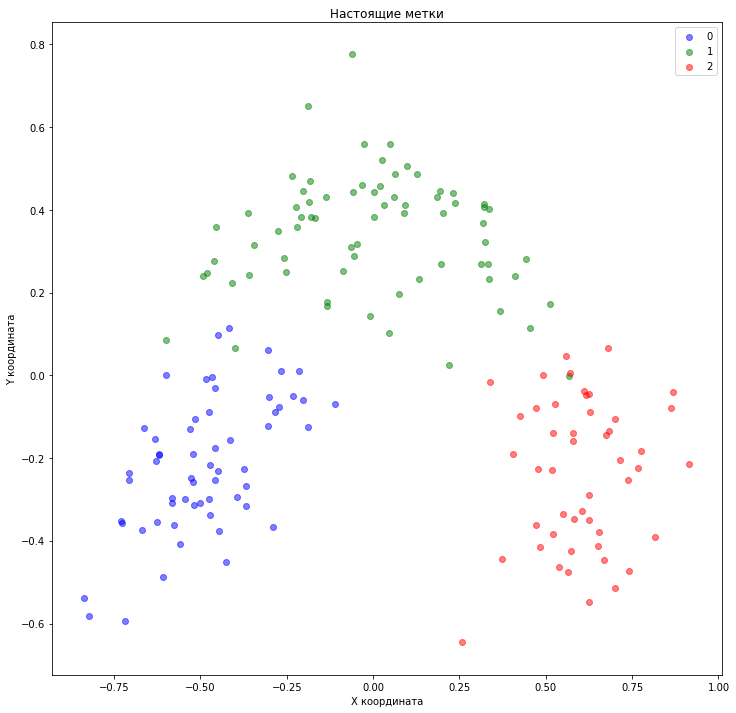

In [40]:
display_clusters(y, "Настоящие метки")

In [45]:
class KMeansPP:
    def __init__(self, n_clusters, eps=1e-7, max_iters=10000):
        self.n_clusters = n_clusters
        self.eps = eps
        self.max_iters = max_iters
        
    
    def init_centroids(self, X):
        cnt, dim = X.shape
        centroids = []
        first_idx = np.random.randint(0, cnt)
        centroids.append(X[first_idx])
        for _ in range(self.n_clusters - 1):
            min_distances = np.apply_along_axis(lambda x: KMeansPP.find_nearest_from(centroids, x)[1], 1, X)
            sorted_idxs = np.argsort(min_distances)
            dist_sum = np.sum(min_distances)
            p = random.random()
            while p == 0:
                p = random.random()
            cur_dist = p * dist_sum
            cur_idx = 0
            cur_sum = min_distances[sorted_idxs[0]]
            while cur_sum < cur_dist:
                cur_idx += 1
                cur_sum += min_distances[sorted_idxs[cur_idx]]
            centroids.append(X[sorted_idxs[cur_idx]])
        self.centroids = np.array(centroids)
        
        
    @staticmethod
    def calc_dist(a, b):
        return np.linalg.norm(a - b)
    
    
    @staticmethod
    def find_nearest_from(points, x):
        distances = np.apply_along_axis(lambda c: KMeansPP.calc_dist(c, x), 1, points)
        idx = np.argmin(distances)
        return idx, distances[idx]
        
        
    def find_nearest_centroid(self, x):
        idx, dist = KMeansPP.find_nearest_from(self.centroids, x)
        return idx
        
        
    def fit(self, X):
        self.init_centroids(X)
        cnt, dim = X.shape
        for _ in range(self.max_iters):
            cluster_size = np.zeros(self.n_clusters, dtype=int)
            cluster_sum = np.zeros((self.n_clusters, dim))
            for x in X:
                c_idx = self.find_nearest_centroid(x)
                cluster_size[c_idx] += 1
                cluster_sum[c_idx] += x
            new_centroids = np.copy(self.centroids)
            for i in range(self.n_clusters):
                if cluster_size[i] != 0:
                    new_centroids[i] = cluster_sum[i] / cluster_size[i]
            diffs = np.apply_along_axis(lambda diff: np.linalg.norm(diff), 1, self.centroids - new_centroids)
            if np.max(diffs) <= self.eps:
                break
            self.centroids = new_centroids
            
            
    def transform_one(self, x):
        return self.find_nearest_centroid(x)
    
    
    def transform(self, X):
        return np.apply_along_axis(self.transform_one, 1, X)
    
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [42]:
my_labels = KMeansPP(n_clusters=3).fit_transform(X_norm)

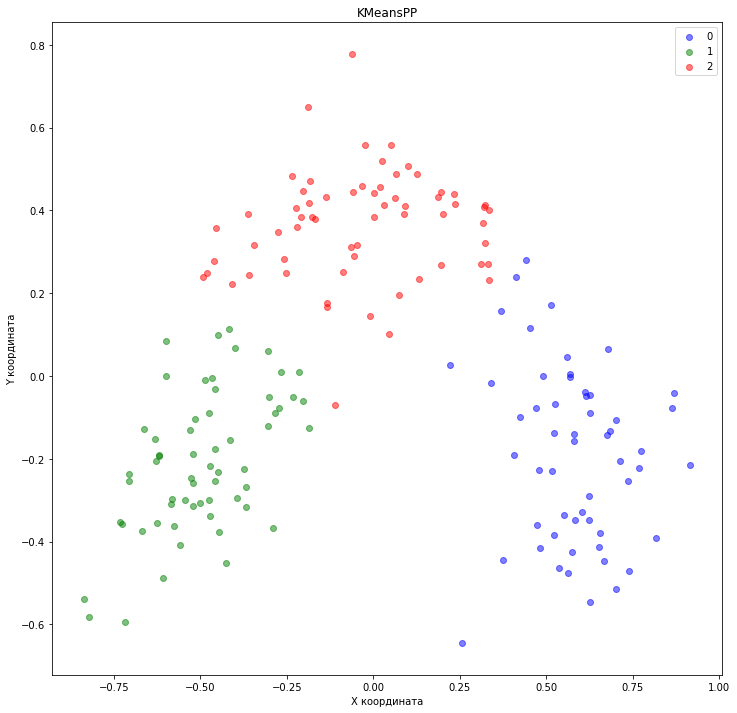

In [43]:
display_clusters(my_labels, "KMeansPP")

In [51]:
def mean_inner_distance(X, labels):
    res = 0
    unique_labels = np.unique(labels)
    for label in labels:
        idxs = np.where(labels == label)
        elems = X[idxs]
        cnt, *_ = elems.shape
        if cnt == 0:
            continue
        centroid = np.sum(elems, axis=0) / cnt
        sum_dist = np.sum(np.apply_along_axis(lambda e: KMeansPP.calc_dist(e, centroid) ** 2, 1, elems))
        res += sum_dist / cnt
    return res

In [44]:
adjusted_rand_score(y, my_labels)

0.8368448733145885

In [52]:
mean_inner_distance(X_norm, my_labels)

48.970291155139385

In [57]:
clusters_cnt = [i for i in range(1, 10)]
inner_metrics = []
external_metrics = []
for clusters in clusters_cnt:
    labels = KMeansPP(n_clusters=clusters).fit_transform(X_norm)
    inner_metrics.append(mean_inner_distance(X_norm, labels))
    external_metrics.append(adjusted_rand_score(y, labels))

In [58]:
def display_metrics(clusters, metrics, title):
    plt.figure(figsize=(12, 9))
    plt.grid(linestyle='--')
    plt.plot(clusters, metrics, linestyle='-',marker='.',color='r')
    plt.title(title)
    plt.xlabel("Количество кластеров")
    plt.ylabel("Значение метрики")
    plt.show()

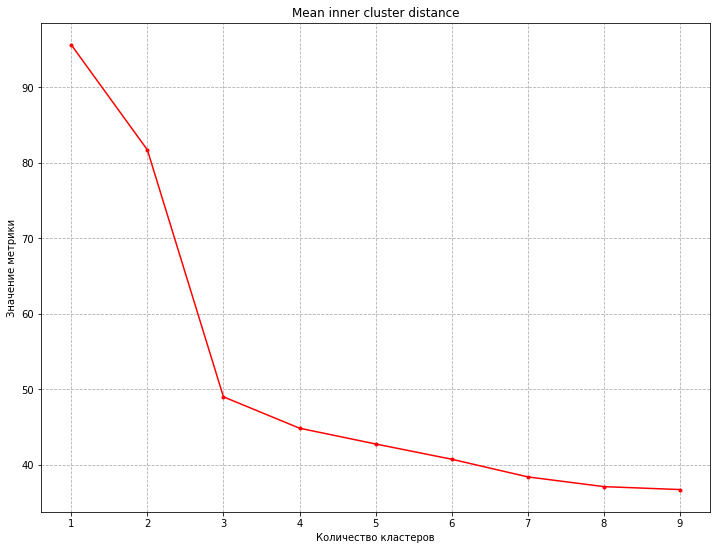

In [59]:
display_metrics(clusters_cnt, inner_metrics, "Mean inner cluster distance")

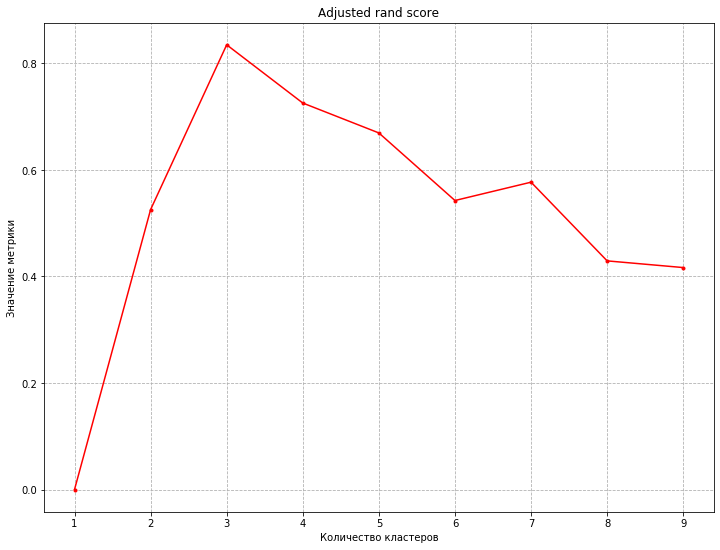

In [60]:
display_metrics(clusters_cnt, external_metrics, "Adjusted rand score")